# Winning at Jeopardy
Jeopardy is a popular game show in the US where contestants answer questions to win money.  In this project, we will analyze a dataset that contains 20,000 rows of Jeopardy questions and anwers to look for patterns that could help a future contestant win.  These 20,000 rows only account for about 10% of the total dataset.

We will begin by importing the dataset and getting acquainted with the data.

In [1]:
import pandas as pd

In [2]:
#read in the data and see the first five rows
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
#look at actual column names
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

Some of the columns have spaces in front of the column name.  Let's remove all spaces to help cut down on mistakes later on.

In [4]:
#clean column names
jeopardy.columns = ['Show_Number','Air_Date','Round','Category',
                   'Value','Question','Answer']

### Clean the data
Since the data is in text format and we're interested in finding patterns, we'll need to normalize the text to remove any punctuations and lowercase everything.  We don't want the analysis to consider words like <code>"Don't"</code> and <code>"don't"</code> differently.  

In [5]:
#using regular expressions, clean the text
import re
def normalize_text(text):
    text = text.lower()
    text = re.sub('[^A-Za-z0-9\s]','', text)
    text = re.sub('\s+',' ', text)
    return text

Now that we have a function to normalize the text, let's clean the Question and Answer columns.

In [6]:
#create new columns with cleaned data
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)

Now that we have those columns cleaned.  We'll need to clean the value columns.  We want the <code>"Value"</code> column to be numeric and remove the dollar sign.  For the <code>"Air_date"</code> column, we'll want that to be a datetime.

In [7]:
#using regular expressions, extract the value in integer format
def normalize_value(value):
    value = re.sub('[^A-Za-z0-9\s]','', value)
    try:
        value = int(value)
    except Exception:
        value = 0
    return value

In [8]:
#create new columns with clean data
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)
jeopardy['Air_Date'] = pd.to_datetime(jeopardy['Air_Date'])

### Finding Patterns
Now that we have the data ready, we'll want to see if we can answer a few questions to see if the contestant would be better studying past questions, studying general knowledge, or to not study at all.  In order to figure this out, it will be helpul to figure out:

- How ofter the answer can be used for a question

- How often questions are repeated

We can answer the first question by seeing how many times words in the answer also occur in the question.  The second question we can answer by seeing how often complex words (>6 characters) reoccur.

We'll start with the first question and write a function that counts the words in both the question and answer column and then compare the counts to find matches.

In [9]:
#create function that compares words from the question and answer
def match_count(row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0
    if 'the' in split_answer:
        split_answer.remove('the')
    if len(split_answer) == 0:
        return 0
    for answer in split_answer:
        if answer in split_question:
            match_count += 1
    return match_count / len(split_answer)       

In [10]:
#create new column with whether it matched or not
jeopardy['answer_in_question'] = jeopardy.apply(match_count,axis=1)

In [11]:
#find the mean
jeopardy['answer_in_question'].mean()

0.059001965249777744

Given that only 6% of the question is included in the answer, this does not bode well for figuring out the answer based on the question alone.  It might be best to study.

### Repeating Questions
Now that we established that we need to study, let's see if we can find any repeating questions.

Let's write a function that will create a counter that keeps track of complex words.

In [12]:
#create function to track reused words
question_overlap = []
terms_used = set()
term_dict = {}
jeopardy = jeopardy.sort_values('Air_Date')

for i, row in jeopardy.iterrows():
    split_question = row['clean_question'].split()
    split_question = [q for q in split_question if len(q) > 5 and len(q) < 15]
    match_count = 0
    for question in split_question:
        if question in terms_used:
            match_count += 1
    for question in split_question:
        if question in term_dict:
            term_dict[question] += 1
        else:
            term_dict[question] = 1
    for question in split_question:
        terms_used.add(question)
    if len(split_question) > 0:
        match_count /= len(split_question)
    question_overlap.append(match_count)
jeopardy['question_overlap'] = question_overlap
print('Percentage Recycled: ',jeopardy['question_overlap'].mean()*100)
print('Top 20 used words: ',sorted(term_dict, key=term_dict.get, reverse=True)[:20])

Percentage Recycled:  69.50624329703908
Top 10 used words:  ['called', 'country', 'played', 'became', 'before', 'president', 'american', 'capital', 'famous', 'french', 'island', 'people', 'national', 'largest', 'little', 'around', 'british', 'author', 'meaning', 'during']


About 70% of terms are being recycled.  Although, this function only takes into account individual terms and not full phrases, it may be worth investigating further.  However, looking at the top 20 words, they don't seem to be all that helpful.

### High vs Low Value Questions
It may be helpful to focus on studying high value questions since this will gain us the most money for correct answers.

We can solve this by using a chi-squared test.  In order to solve for this, we'll need to create two categories:

- Low Value with <code>"Value"</code> being less than 800.

- High Value with <code>"Value"</code> being greater than 800.

Once we have those two categories, we can loop through each term from <code>"terms_used"</code> and:

- Find the number of low value questions the word occurs in.

- Find the number of high value questions the word occurs in.

- Find the percentage of questions the word occurs in.

- Based on the percentage of questions the word occurs in, find expected counts.

- Compute the chi squared value based on the expected counts and the observed counts for high and low value questions.

Once we have completed all of that, we can find the words that have the biggest differences in usage between high and low value questions by selecting the words with the highest associated chi-squared values.

Doing this for all words will take a very long time, so we'll focus on a small sample for illustrative purposes.

In [13]:
#create function to separate high value (1) vs low value (0)
def create_value(row):
    value = 0
    if row['clean_value'] > 800:
        value = 1
    return value

In [14]:
#create new column with high vs low value
jeopardy['high_value'] = jeopardy.apply(create_value,axis=1)

In [15]:
#create function to give high and low value counts based on term
def term_count(text):
    low_count = 0
    high_count = 0
    for i,row in jeopardy.iterrows():
        if text in row['clean_question'].split(' '):
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

Now that we have the function that will give us the high value or low value count based on the terms used, we can run it.  We'll start by running it on 10 randomly picked elements from the <code>"terms_used"</code> set we have.

In [16]:
#using 10 random terms from our terms used set
from random import choice

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for word in range(10)]

#based on the term, return high and low value counts
observed_expected = []
observed_expected_dict = {}
for term in comparison_terms:
    count = term_count(term)
    observed_expected.append(count)
    observed_expected_dict[term] = count
    print("Term Used: ",term)
    print("Count(High,Low): ", count)
    print('-'*25)

Term Used:  leslie
Count(High,Low):  (2, 6)
-------------------------
Term Used:  condemned
Count(High,Low):  (1, 3)
-------------------------
Term Used:  replayed
Count(High,Low):  (0, 1)
-------------------------
Term Used:  palauan
Count(High,Low):  (1, 0)
-------------------------
Term Used:  granth
Count(High,Low):  (0, 1)
-------------------------
Term Used:  bernadette
Count(High,Low):  (0, 1)
-------------------------
Term Used:  rising
Count(High,Low):  (3, 10)
-------------------------
Term Used:  ionesco
Count(High,Low):  (1, 0)
-------------------------
Term Used:  habibie
Count(High,Low):  (1, 0)
-------------------------
Term Used:  wessex
Count(High,Low):  (0, 2)
-------------------------


Here we have the observed counts for the terms randomly picked.  Now we can compute the expected counts and then the chi-squared value.

In [17]:
#run chi-square test to calculate p-values
from scipy.stats import chisquare
import numpy as np

high_value_count = jeopardy[jeopardy['high_value'] == 1].shape[0]
low_value_count = jeopardy[jeopardy['high_value'] == 0].shape[0]

chi_squared = []
for category, observed in observed_expected_dict.items():
    total = sum(observed)
    total_prop = total / jeopardy.shape[0]
    high_value_expected = total_prop * high_value_count
    low_value_expected = total_prop * low_value_count
    
    observed_final = np.array([observed[0],observed[1]])
    expected_final = np.array([high_value_expected,low_value_expected])
    chi_square = chisquare(observed_final,expected_final)
    print('Category: ', category)
    print(chi_square)
    print('-'*75)
    chi_squared.append(chi_square)

Category:  leslie
Power_divergenceResult(statistic=0.05272886616881538, pvalue=0.818381104912348)
---------------------------------------------------------------------------
Category:  condemned
Power_divergenceResult(statistic=0.02636443308440769, pvalue=0.871013484688921)
---------------------------------------------------------------------------
Category:  replayed
Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469)
---------------------------------------------------------------------------
Category:  palauan
Power_divergenceResult(statistic=2.487792117195675, pvalue=0.11473257634454047)
---------------------------------------------------------------------------
Category:  granth
Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469)
---------------------------------------------------------------------------
Category:  bernadette
Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469)
-------------------------

Since the p_value is way higher than the standard threshold of 5%, we fail to reject the null hypotheis.  It seems that there is no significance in the actual term used between high vs low values.

### Highest Value Categories and Rounds
Since focusing on just terms used doesn't seem too helpful with studying, we should take a look at the overall categories and how they relate to the Jeopardy rounds.  If we can narrow down to a few categories that might net us the highest value, these would be good categories for a broad study guide.

In [18]:
#Frequency of Rounds
jeopardy['Round'].value_counts()

Jeopardy!           9901
Double Jeopardy!    9762
Final Jeopardy!      335
Tiebreaker             1
Name: Round, dtype: int64

In [19]:
#create a cross table to count high vs low value questions per round
cross_table = pd.crosstab(jeopardy['Round'],jeopardy['high_value'])
cross_table

high_value,0,1
Round,,
Double Jeopardy!,5340,4422
Final Jeopardy!,335,0
Jeopardy!,8589,1312
Tiebreaker,1,0


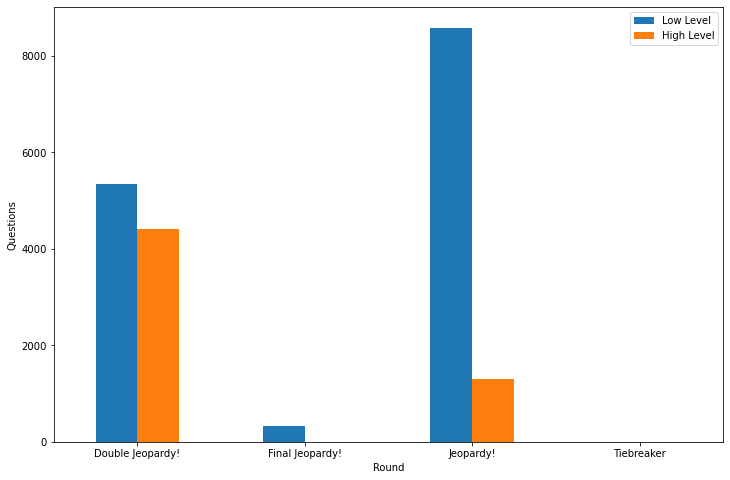

In [20]:
#visualize the difference
import matplotlib.pyplot as plt
cross_table.plot.bar(figsize = (12,8), rot = 0)
plt.ylabel('Questions')
plt.legend(['Low Level','High Level'])

In [21]:
from scipy.stats import chi2_contingency

In [22]:
#run chi-square on the cross table
chi_sq,p_value,dof,expected = chi2_contingency(cross_table)
p_value

0.0

Looking at the cross table and bar plot, it seems that Double Jeopardy has the most high value questions and running a chi-squared test, we can see that the p-value is rounded to 0.  This means we can reject the null hypothesis of this happening by chance.  We can assume that focusing on Double Jeopardy questions may net us the most points.

Let's take a look at the categories now.

In [23]:
#Top 20 Categories
jeopardy['Category'].value_counts().head(20)

TELEVISION          51
U.S. GEOGRAPHY      50
LITERATURE          45
BEFORE & AFTER      40
HISTORY             40
AMERICAN HISTORY    40
AUTHORS             39
WORD ORIGINS        38
WORLD CAPITALS      37
SPORTS              36
BODIES OF WATER     36
RHYME TIME          35
MAGAZINES           35
SCIENCE             35
SCIENCE & NATURE    35
WORLD GEOGRAPHY     33
WORLD HISTORY       32
HISTORIC NAMES      32
ANNUAL EVENTS       32
BIRDS               31
Name: Category, dtype: int64

In [24]:
#create function to count high vs low value count based on category
def category_count(cat):
    low_count = 0
    high_count = 0
    for i,row in jeopardy.iterrows():
        if cat in row['Category']:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [25]:
#using top 20 categories, return high vs low value count
top_20_categories = jeopardy['Category'].value_counts().head(20).index
observed_expected_cat = []
observed_expected_cat_dict = {}
for category in top_20_categories:
    count = category_count(category)
    observed_expected_cat.append(count)
    observed_expected_cat_dict[category] = count
    print("Category: ",category)
    print("Count(High,Low): ", count)
    print('-'*25)

Category:  TELEVISION
Count(High,Low):  (9, 56)
-------------------------
Category:  U.S. GEOGRAPHY
Count(High,Low):  (14, 36)
-------------------------
Category:  LITERATURE
Count(High,Low):  (45, 113)
-------------------------
Category:  BEFORE & AFTER
Count(High,Low):  (28, 25)
-------------------------
Category:  HISTORY
Count(High,Low):  (69, 210)
-------------------------
Category:  AMERICAN HISTORY
Count(High,Low):  (12, 28)
-------------------------
Category:  AUTHORS
Count(High,Low):  (33, 85)
-------------------------
Category:  WORD ORIGINS
Count(High,Low):  (12, 26)
-------------------------
Category:  WORLD CAPITALS
Count(High,Low):  (8, 29)
-------------------------
Category:  SPORTS
Count(High,Low):  (38, 156)
-------------------------
Category:  BODIES OF WATER
Count(High,Low):  (11, 40)
-------------------------
Category:  RHYME TIME
Count(High,Low):  (36, 99)
-------------------------
Category:  MAGAZINES
Count(High,Low):  (7, 38)
-------------------------
Category:  

In [26]:
#Run chi-square test on categories
chi_squared_2 = []
for category,observed in observed_expected_cat_dict.items():
    total = sum(observed)
    total_prop = total / jeopardy.shape[0]
    high_value_expected = total_prop * high_value_count
    low_value_expected = total_prop * low_value_count
    
    observed_final = np.array([observed[0],observed[1]])
    expected_final = np.array([high_value_expected,low_value_expected])
    chi_square = chisquare(observed_final,expected_final)
    print('Category: ',category)
    print(chi_square)
    print('-'*80)
    chi_squared_2.append(chisquare(observed_final,expected_final))

Category:  TELEVISION
Power_divergenceResult(statistic=6.9856407222578145, pvalue=0.008216623309889584)
--------------------------------------------------------------------------------
Category:  U.S. GEOGRAPHY
Power_divergenceResult(statistic=0.011022071015878569, pvalue=0.9163868768161757)
--------------------------------------------------------------------------------
Category:  LITERATURE
Power_divergenceResult(statistic=0.0028013893381219745, pvalue=0.9577891532938911)
--------------------------------------------------------------------------------
Category:  BEFORE & AFTER
Power_divergenceResult(statistic=15.125581107749277, pvalue=0.00010059095507507294)
--------------------------------------------------------------------------------
Category:  HISTORY
Power_divergenceResult(statistic=2.118063742523984, pvalue=0.145570478361707)
--------------------------------------------------------------------------------
Category:  AMERICAN HISTORY
Power_divergenceResult(statistic=0.03452340

Looking at the p-values, the ones that are below the 5% threshold are the following:
- Television
- Before & After
- Sports 
- Science
- Birds

Let's visualize this further

In [27]:
#Filter based on categories and create cross table of high vs low value question count
cats = ['TELEVISION','BEFORE & AFTER','SPORTS','SCIENCE','BIRDS']
filtered_cats = jeopardy[jeopardy['Category'].isin(cats)]
cats_cross_table = pd.crosstab(filtered_cats['Category'],filtered_cats['high_value'])
cats_cross_table

high_value,0,1
Category,,
BEFORE & AFTER,21,19
BIRDS,29,2
SCIENCE,20,15
SPORTS,30,6
TELEVISION,45,6


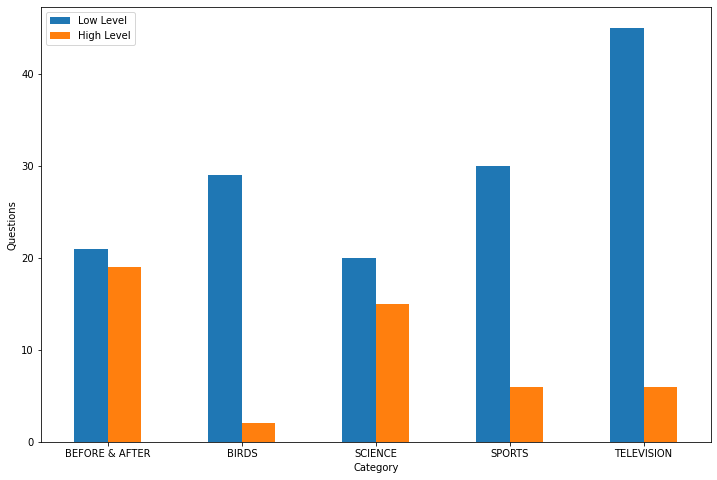

In [28]:
#visulaize the cross table
cats_cross_table.plot.bar(rot=0,figsize=(12,8))
plt.ylabel('Questions')
plt.legend(['Low Level','High Level'])

Ultimately, if we want to focus on the categories that have the potential to net us the highest value, we should focus on <code>'Science'</code> and <code>'Before & After'</code>.

Out of curiousity, we can see which rounds the top 2 High Value categories appear in.

In [29]:
#filter based on category
b_and_a = filtered_cats[filtered_cats['Category'] == 'BEFORE & AFTER']
science = filtered_cats[filtered_cats['Category'] == 'SCIENCE']

In [30]:
#round frequency for before & after
b_and_a['Round'].value_counts()

Double Jeopardy!    30
Jeopardy!           10
Name: Round, dtype: int64

In [31]:
#round frequency for science
science['Round'].value_counts()

Double Jeopardy!    25
Jeopardy!           10
Name: Round, dtype: int64

As expeceted, most of the questions are in Double Jeopardy.  This is the round that offers the highest value questions.

# Conclusion
Winning at Jeopardy is definitely a skill and those who are very good are more than likely an expert in numerous categories.  Analayzing a small portion of a larger dataset, we found that it's very tough to gain an advantage through looking at patterns in the types of questions via terminology used.  We were however able to find a couple of categories that are used frequently and have the potential to net higher values.  These were <code>'Science'</code> and <code>'Before & After'</code>.  Also, Double Jeopardy had the highest amount of high value questions as well.  The contestant can use that knowledge to gain an advantage.

A great place for a contestant to study, would be to focus on frequently used categories and the categories that offer high value questions.